# Eyes in the Sky: Predicting Aircraft Damage Caused by Bird Strikes Using Machine Learning
## Part 2: Coefficients and Modeling

Alan da Silveira Fleck
<br>
alansfleck@gmail.com
<br>
27/09/2021

# Introduction

In this notebook, we extend the insights gathered from the EDA of Part 1 and further develop them to answer the following questions: What are the factors associated with damaging bird strikes? Can we predict these events?

Thus, Part 2 of this project aims to identify the coefficients associated with damaging strikes and to use supervised machine learning to predict the outcome of these incidents.

For the former objective, a statistical model using Logistic Regression was used. For the latter objective, the initial predictive models explored were `Logistic Regression`, `K-Nearest Neighbors (KNN)`, `Support Vector Machines (SVM)`, and `Decision Trees`, as well as advanced models like `Random Forest` and `XGBoost`. 



## Importing Packages and Reading the Data

To answer the objectives listed above, we will use the dataset cleaned in Part 1 of this project. The codes below import the relevant packages and read the cleaned data into a data frame.

In [1]:
# Importing the relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# statsmodel
import statsmodels.api as sm
from statsmodels.regression import linear_model

# machine learning packages
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, roc_auc_score



In [2]:
# Reading the csv file into a data frame
cleaned_df = pd.read_csv('data/cleaned_df.csv')

# This will show all columns when calling df.head()
pd.set_option("display.max_columns", None)

# Checking the first 5 rows of the dataset
cleaned_df.head()

,is_airplane,is_more_1000ft,number_struck,is_damaged,number_engines,is_precipitation,wildlife_size,conditions_sky,is_pilot_warned,is_aircraft_large,Year,Month,Weekday,flight_phase_Approach,flight_phase_Climb,flight_phase_Descent,flight_phase_Landing Roll,flight_phase_Parked,flight_phase_Take-off run,flight_phase_Taxi,regions_Canada,regions_International,regions_Region_1,regions_Region_10,regions_Region_2,regions_Region_3,regions_Region_4,regions_Region_5,regions_Region_6,regions_Region_7,regions_Region_8,regions_Region_9
0,1,1,3,1,2,0,1,0,0,1,2000,11,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,3,1,2,0,0,1,1,0,2001,7,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,3,0,2,0,0,0,0,0,2001,9,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,3,0,2,0,0,1,1,1,2002,9,4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,0,3,0,2,0,0,0,0,0,2003,6,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


# Statistical Analysis:  Logistic Regression with Statsmodels

The aim of this sub-section was to determine how the independent variables affect damaging strikes (`is_damaged` is the dependent variable). For this, Backward Stepwise Logistic Regression was applied. 

The first step, however, was to separate the dependent and independent variables into `y_stat` and `X_stat`, respectively. When selecting the independent variables, the redundant dummy variables (`flight_phase_taxi` and `regions_Canada` in this case) were removed because they bring no extra information and may cause collinearity when using _statsmodels_. However, this will not be a problem when using _sci-kit_ learn later in this notebook because of the implemented penalization of the coefficients.

In [3]:
# Select the independent variables (i.e. X). Also, remove the redundant dummy variable 'flight_phase_Taxi' and 'regions_Canada'
X_stat = cleaned_df.drop(columns = ['flight_phase_Taxi', 'regions_Canada', 'is_damaged'])
y_stat = cleaned_df['is_damaged']

As seen in the EDA of Part 1, our target variable is divided as 9.7% of damaging strikes and 90.3% of non-damaging strikes. This class imbalance may result in difficulties when interpreting the models since, in this case, a model accuracy of 90% would be the result of chance and not an indicator of a good predictive model. Thus, class 0 (i.e. non-damaging strikes) was downsampled to match the number of observations of class 1 (i.e. damaging strikes).

In [4]:
# Downsample
print('Number of class 0 examples before:', X_stat[y_stat == 0].shape[0])

X_downsampled, y_downsampled = resample(X_stat[y_stat == 0], 
                                        y_stat[y_stat == 0], 
                                        replace=True, 
                                        n_samples=X_stat[y_stat == 1].shape[0], 
                                        random_state=123)

print('Number of class 0 examples after:', X_downsampled.shape[0])

# Combine upsample with original data
X_stat_ds = np.vstack((X_stat[y_stat == 1], X_downsampled))
y_stat_ds = np.hstack((y_stat[y_stat == 1], y_downsampled))

# Transform in a data frame
X_stat_ds = pd.DataFrame(columns=X_stat.columns, data=X_stat_ds)

Number of class 0 examples before: 23081
Number of class 0 examples after: 2477


### Correlations Between Predictors

Multicollinearity is the situation where your independent variables are highly correlated with each other. This may affect the calculation of coefficients and impact the predictions of the model. Thus, the next step involved the assessment of the correlation coefficients between the independent variables.  

Correlation coefficients higher than 0.4 or lower than -0.4 were considered indicative of multicollinearity. In this case, one of the correlated variables was removed. The criteria for removing a correlated variable were based on the lowest impact that it could have on the model (from EDA of Part 1) and/or if it was also correlated with a second variable.

Below, we can see a positive correlation `condition_sky` and `is_precipitation` (r = 0.47),  as well as a negative correlation between `flight_phase_Approach` and `flight_phase_Climb` (r = -0.44). 

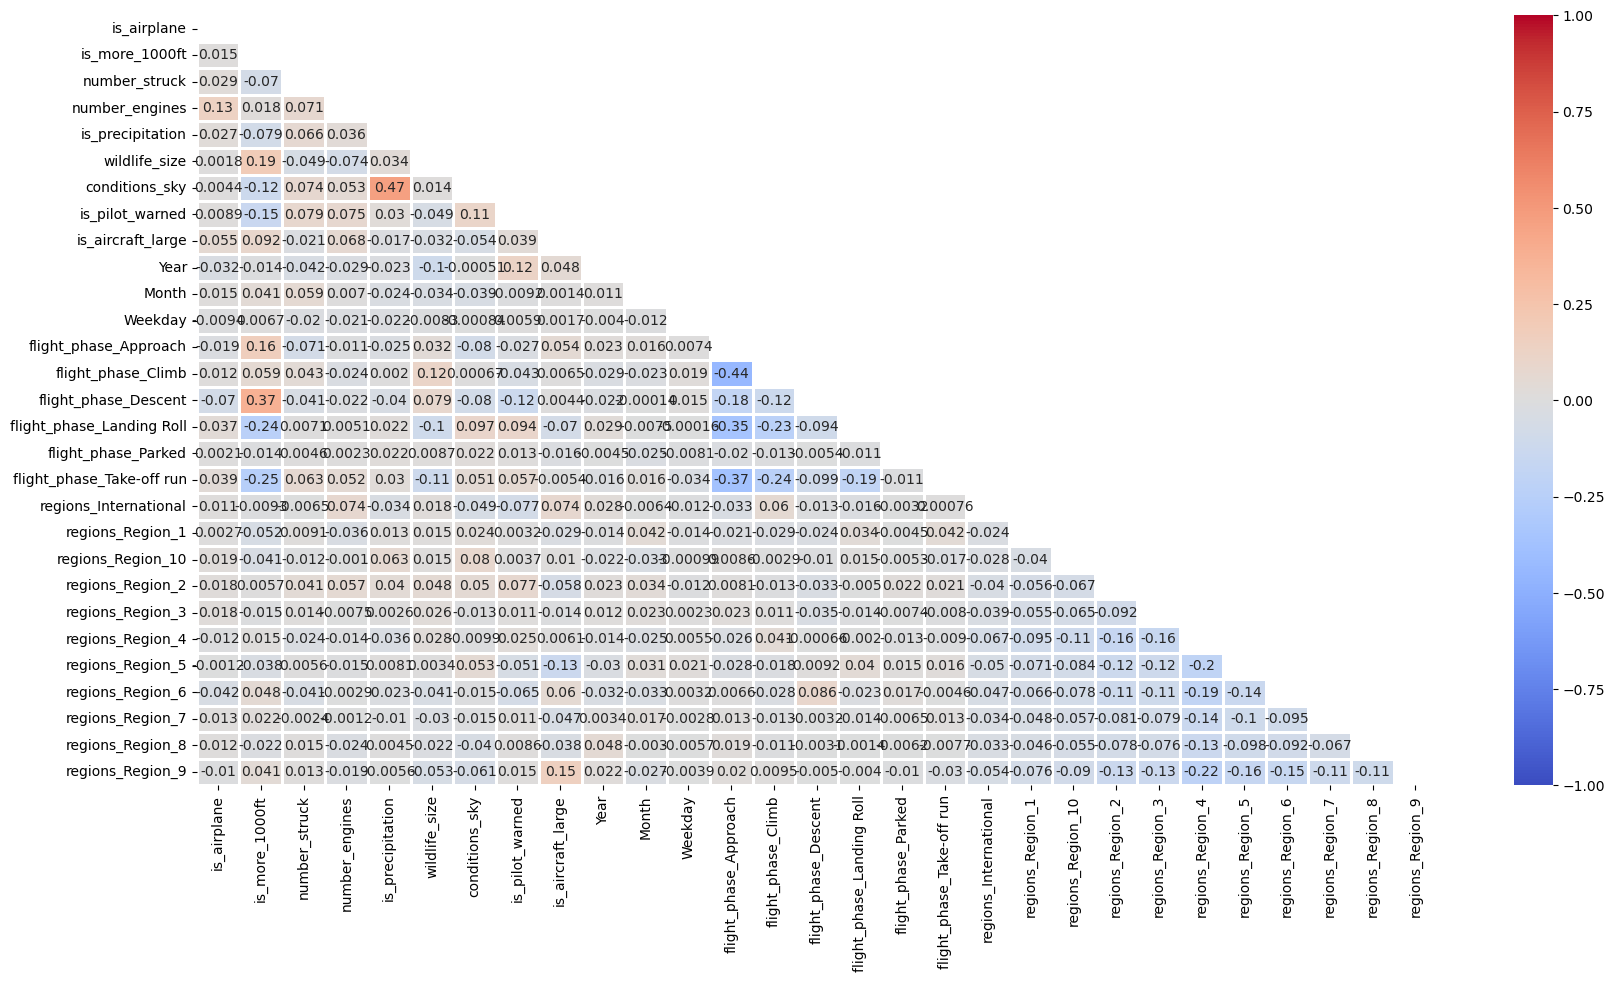

In [5]:
# Correlations
plt.figure(figsize=(20,10))
matrix = np.triu(X_stat_ds.corr())
sns.heatmap(X_stat_ds.corr(), cmap='coolwarm', mask=matrix, vmin=-1, vmax=1, annot=True, lw=1)
plt.show()

The variables `flight_phase_Approach` and `is_precipitation` were removed from the model. The new correlation coefficients show no other clear signs of multicollinearity between the independent variables, as seen below.

In [6]:
# Dropping 'flight_phase_Approach' and 'is_precipitation' because r > 0.4 with other variables (colinearity)
X_stat_ds.drop(columns=['flight_phase_Approach','is_precipitation'] , inplace=True)

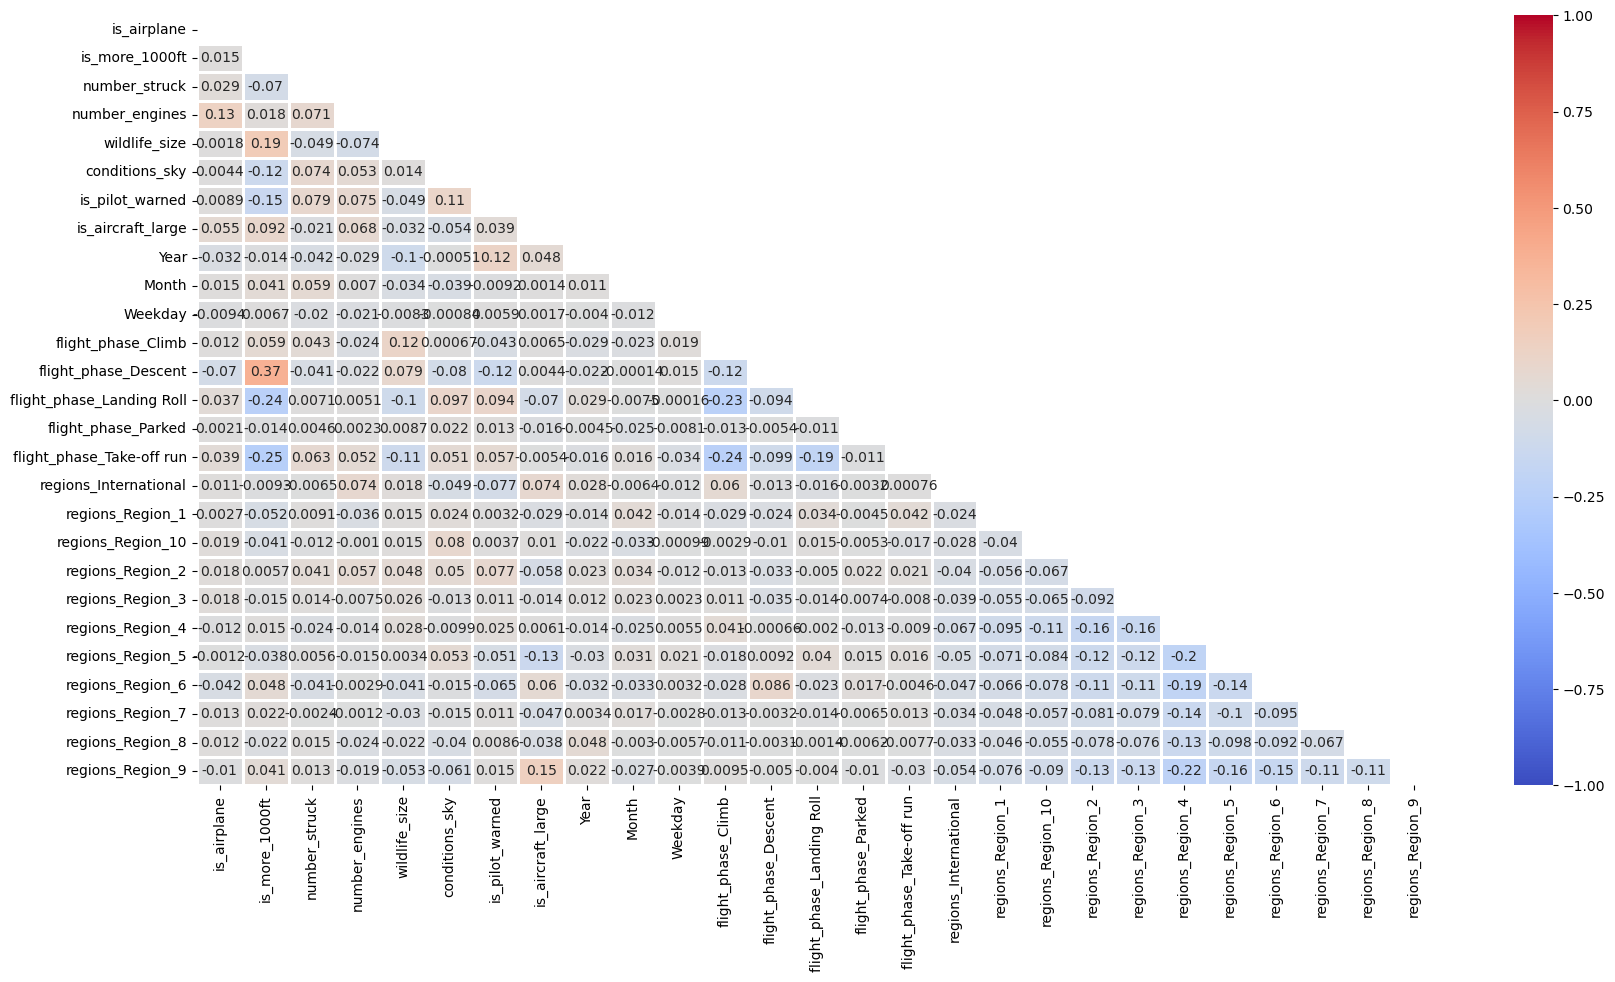

In [7]:
# Correlations
plt.figure(figsize=(20,10))
matrix = np.triu(X_stat_ds.corr())
sns.heatmap(X_stat_ds.corr(), cmap='coolwarm', mask=matrix, vmin=-1, vmax=1, annot=True, lw=1)
plt.show()

### Backward Stepwise Logistic Regression

Next, logistic regression was performed using a backward stepwise process. In this approach, we begin with a full  model and, at each step, we gradually eliminate non-statistically significant variables (i.e. P > 0.05) from the regression model to find a reduced model that best explains the data.

Below, the full model is fitted.

##### Model 1 (Full Model)

In [8]:
warnings.filterwarnings('ignore')

# add constant 1 column
X_const = sm.add_constant(X_stat_ds)

# initialize model with dependent variable and the predictors
logit = sm.Logit(y_stat_ds, X_const)

# fit the model
logit = logit.fit()

# Get the summary
logit.summary()

Optimization terminated successfully.
         Current function value: 0.500619
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4954
Model:                          Logit   Df Residuals:                     4926
Method:                           MLE   Df Model:                           27
Date:                Thu, 23 Sep 2021   Pseudo R-squ.:                  0.2778
Time:                        19:49:22   Log-Likelihood:                -2480.1
converged:                       True   LL-Null:                       -3433.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        71.1129     20.931      3.398      0.001      30.089     112.136
is_airplane                  -0.3188      0.400     -0.798      0.425      -1.102       0.465
is_more_1000ft                0.3418      0.099      3.460      0.001       0.148       0.535
number_struck                 0.9363      0.075     12.442      0.000       0.789       1.084
number_engines               -0.4236      0.090     -4.699      0.000      -0.600      -0.247
wildlife_size                 1.6541      0.053     31.103      0.000       1.550       1.758
conditions_sky                0.0846      0.048      1.760      0.078      -0.010       0.179
is_pilot_warned              -0.0473      0.075     -0.633      0.527      -0.194       0.099
is_aircraft_large            -0.6003      0.081     -7.406      0.000      -0.759      -0.441
Year                         -0.0356      0.010     -3.417      0.001      -0.056      -0.015
Month                         0.0020      0.012      0.170      0.865      -0.021       0.025
Weekday                       0.0345      0.018      1.923      0.054      -0.001       0.070
flight_phase_Climb            0.4400      0.093      4.719      0.000       0.257       0.623
flight_phase_Descent          0.5124      0.188      2.721      0.007       0.143       0.882
flight_phase_Landing Roll    -0.7822      0.117     -6.710      0.000      -1.011      -0.554
flight_phase_Parked           0.5301      1.502      0.353      0.724      -2.415       3.475
flight_phase_Take-off run     0.1483      0.103      1.433      0.152      -0.055       0.351
regions_International         0.3756      0.552      0.681      0.496      -0.706       1.457
regions_Region_1             -0.2688      0.520     -0.517      0.605      -1.287       0.750
regions_Region_10             0.6835      0.512      1.334      0.182      -0.320       1.687
regions_Region_2             -0.0279      0.497     -0.056      0.955      -1.002       0.946
regions_Region_3             -0.3390      0.499     -0.680      0.497      -1.317       0.638
regions_Region_4             -0.0502      0.489     -0.103      0.918      -1.009       0.909
regions_Region_5             -0.0836      0.493     -0.170      0.865      -1.050       0.882
regions_Region_6             -0.0397      0.494     -0.080      0.936      -1.008       0.929
regions_Region_7             -0.2550      0.503     -0.507      0.612      -1.241       0.731
regions_Region_8              0.1720      0.504      0.341      0.733      -0.815       1.160
regions_Region_9              0.0877      0.492      0.178      0.858      -0.877       1.052
=============================================================================================
"""

The following independent variables have P > 0.05 and will be dropped from the model: The geographic columns (i.e. `regions_International`, `regions_Region_1`, `regions_Region_10`, `regions_Region_2`, `regions_Region_3`, `regions_Region_4`, `regions_Region_5`, `regions_Region_6`, `regions_Region_7`, `regions_Region_8` and `regions_Region_9`), as well as  `is_airplane`, `is_pilot_warned`, `Month`, `flight_phase_Parked`, `flight_phase_Take-off run`.
<br>
<br>
`condition_sky` and `Weekday` are very close to the threshold of statistical significance. These variables will be kept in the model to verify how the removal of the other columns affects their coefficients.
<br>
<br>
Below, we can also see that this first model has an accuracy of 76.77%.

In [9]:
# soft predictions
y_proba = logit.predict(X_const)

# hard predictions by applying a threshold
y_pred = np.where(y_proba >= 0.5, 1, 0)

# num of correct predictions
num_correct = (y_pred == y_stat_ds).sum()

# accuracy
accuracy = num_correct / y_pred.shape[0]

print(f"The model accuracy is {round(accuracy*100, 2)}%")

The model accuracy is 76.77%


| Model | Accuracy |
| ----- | -------- |
| Model A | 76.77% 

#### Model 2

Next, we will drop the variable identified above and re-fit the model.

In [10]:
# we will drop the columns with p-values much higher than 0.05 and perform another regression
X_stat_ds2 = X_stat_ds.drop(columns=['regions_International', 'regions_Region_1', 'regions_Region_10', 'regions_Region_2',
                        'regions_Region_3', 'regions_Region_4', 'regions_Region_5', 'regions_Region_6', 
                        'regions_Region_7', 'regions_Region_8','regions_Region_9', 'is_airplane', 'is_pilot_warned',
                        'Month', 'flight_phase_Parked', 'flight_phase_Take-off run'])

In [11]:
# add constant 1 column
X_const = sm.add_constant(X_stat_ds2)

# initialize model with dependent variable and the predictors
logit2 = sm.Logit(y_stat_ds, X_const)

# fit the model
logit2 = logit2.fit()

logit2.summary()

Optimization terminated successfully.
         Current function value: 0.504374
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4954
Model:                          Logit   Df Residuals:                     4942
Method:                           MLE   Df Model:                           11
Date:                Thu, 23 Sep 2021   Pseudo R-squ.:                  0.2723
Time:                        19:49:22   Log-Likelihood:                -2498.7
converged:                       True   LL-Null:                       -3433.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        72.1986     20.567      3.510      0.000      31.888     112.510
is_more_1000ft                0.2912      0.093      3.132      0.002       0.109       0.473
number_struck                 0.9221      0.074     12.406      0.000       0.776       1.068
number_engines               -0.4224      0.088     -4.800      0.000      -0.595      -0.250
wildlife_size                 1.6386      0.053     31.212      0.000       1.536       1.742
conditions_sky                0.0923      0.047      1.959      0.050   -6.58e-05       0.185
is_aircraft_large            -0.5599      0.078     -7.152      0.000      -0.713      -0.406
Year                         -0.0363      0.010     -3.539      0.000      -0.056      -0.016
Weekday                       0.0333      0.018      1.863      0.062      -0.002       0.068
flight_phase_Climb            0.3997      0.087      4.598      0.000       0.229       0.570
flight_phase_Descent          0.5410      0.187      2.898      0.004       0.175       0.907
flight_phase_Landing Roll    -0.8325      0.110     -7.597      0.000      -1.047      -0.618
=============================================================================================
"""

All our coefficients are now statistically significant or very close to significance. As seen below, although we removed 16 variables from the original model, the accuracy of Model 2 is only 0.66% lower than Model 1. 

In [12]:
# soft predictions
y_proba = logit2.predict(X_const)

# hard predictions by applying a threshold
y_pred = np.where(y_proba >= 0.5, 1, 0)

# num of correct predictions
num_correct = (y_pred == y_stat_ds).sum()

# accuracy
accuracy = num_correct / y_pred.shape[0]

print(f"The model accuracy is {round(accuracy*100, 2)}%")

The model accuracy is 76.08%


| Model | Accuracy |
| ----- | -------- |
| Model 1 | 76.77% 
| Model 2 | 76.08%

Next, we will extract the coefficients from Model 2, as well as calculate and plot the odds ratios.

In [13]:
# Lets put this in a dataframe
results_df = pd.DataFrame(logit2.params[1:12], columns=['Coefficient'])

# Calculate and add the odds ratios to results_df_1
# Log odds is more interpretable
results_df['odds_ratio'] = np.exp(results_df['Coefficient'])
results_df = results_df.sort_values(by = ['odds_ratio'], ascending = True)

# Display the data frame
results_df

,Coefficient,odds_ratio
flight_phase_Landing Roll,-0.832485,0.434967
is_aircraft_large,-0.559896,0.571268
number_engines,-0.422437,0.655448
Year,-0.036265,0.964385
Weekday,0.033261,1.033821
conditions_sky,0.092333,1.096730
is_more_1000ft,0.291221,1.338060
flight_phase_Climb,0.399733,1.491426
flight_phase_Descent,0.540987,1.717702
number_struck,0.922144,2.514677


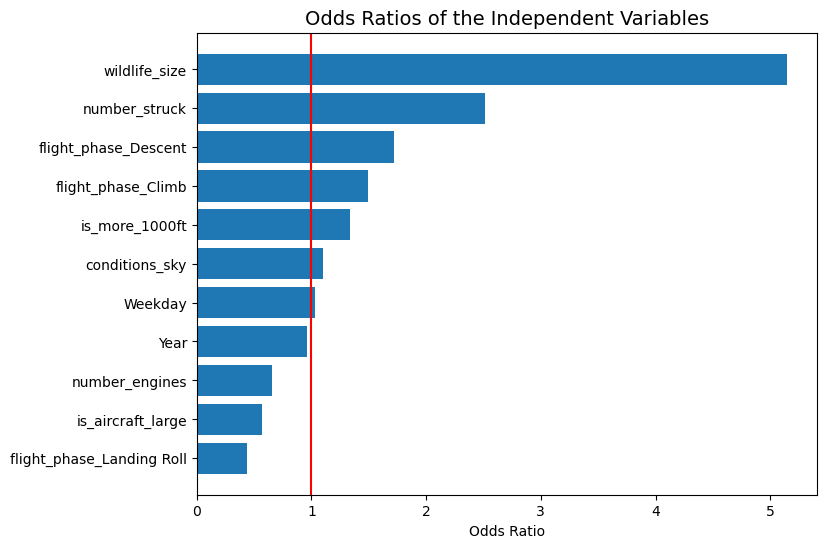

In [14]:
# Plotting the odds rations
plt.figure(figsize = (8, 6))
plt.barh(results_df.index, results_df['odds_ratio'])
plt.title('Odds Ratios of the Independent Variables', fontsize = 14)
plt.xlabel('Odds Ratio', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axvline(x=1, color = 'r')
plt.savefig('OR.png')
plt.show()


As we can see in the figure above, the factors positively related to damaging strikes (i.e. Odds ratio larger than 1) are the size and number of animals, descent and climb phases of the flight, as well as being in an altitude higher than 1000 feet. For instance, the odds of a damaging strike are 5.1 times higher when hitting a large animal compared to a medium-sized animal. Interestingly, these are the variables identified in Part 1 of this project as having a higher damage rate.
<br>
<br>
On the other hand, factors related to the size of the aircraft as well the landing roll phase of the flight are negatively associated with damaging strikes (i.e. Odds ratio smaller than 1) and could be considered "protective" factors. By reversing this line of reasoning, we can conclude that smaller aircraft - in terms of size and number of engines - are more at risk of damaging strikes compared to larger aircrafts.

# Supervised Models 

In the sections below, different supervised machine learning models will be explored in order to identify the one that best predicts damaging strikes. For each model, a base model will be built first, and then the hyperparameter optimization will be performed.
<br>
<br>
However, some preparation steps are necessary in order to correctly run these models.

## Preparation

Similarly to _statsmodel_,  we will separate our columns into the target (i.e. y) and the features (i.e. X), as well as balance our target variable by downsampling the majority class.

In [15]:
# Select the features (i.e. X) and target variable (i.e. y)
X = cleaned_df.drop(columns = ['is_damaged'])
y = cleaned_df['is_damaged']

Two extra steps were added in order to build the models in *scikit-learn* compared to *statsmodels*: train/validation/test split and scaling.
<br>
<br>
The reason for splitting our data into train (or remainder) and test sets is to ensure models do not *overfit* the data they are trained on and can generalize to new data. Also, the reason for including a validation set is to avoid *data leakage* to the test set when performing hyperparameter optimization.

In [16]:
# Taking a chunk for our 20% test set. This will be used for the hyperparameter optimization
X_remainder, X_test, y_remainder, y_test = \
    train_test_split(X, y, test_size = 0.2, random_state=1, stratify = y)

# Splitting the remainder in two chunks for validation and train sets. This will be used for the base models.
X_train, X_validation, y_train, y_validation = \
    train_test_split(X_remainder, y_remainder, test_size = 0.3, random_state=1, stratify = y_remainder)

Downsampling the train set after the split but before scaling.

In [17]:
# Downsample X_train and y_train
print('Number of class 0 examples before:', X_train[y_train == 0].shape[0])


X_downsampled, y_downsampled = resample(X_train[y_train == 0], 
                                        y_train[y_train == 0], 
                                        replace=True, 
                                        n_samples=X_train[y_train == 1].shape[0], 
                                        random_state=123)

print('Number of class 0 examples after:', X_downsampled.shape[0])

# Combine upsample with original data
X_train = np.vstack((X_train[y_train == 1], X_downsampled))
y_train = np.hstack((y_train[y_train == 1], y_downsampled))

Number of class 0 examples before: 12925
Number of class 0 examples after: 1387


In [18]:
# Transform X_train and X_validation back to data frames
X_train = pd.DataFrame(X_train, columns = X.columns)

Most of the machine learning models used in this project require the data to be scaled. For the base models, the MinMax scaler will be used (i.e. each feature, or each dimension, lies exactly between 0 and 1).

In [19]:
# MinMax Scaler the downsampled X_train
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_validation = scaler.transform(X_validation)

In [20]:
# Transform X_train and X_validation back to data frames
X_train = pd.DataFrame(X_train, columns = X.columns)
X_validation = pd.DataFrame(X_validation, columns = X.columns)

Finally, we will downsample the remainder set to be used in the hyperparameter optimization. This set will not be scaled at this moment because this step will be performed inside the pipeline of GridSearchCV when testing different scalers.

In [21]:
# Downsample the X_remainder and y_remainder
print('Number of class 0 examples before:', X_remainder[y_remainder == 0].shape[0])


X_downsampled, y_downsampled = resample(X_remainder[y_remainder == 0], 
                                        y_remainder[y_remainder == 0], 
                                        replace=True, 
                                        n_samples=X_remainder[y_remainder == 1].shape[0], 
                                        random_state=123)

print('Number of class 0 examples after:', X_downsampled.shape[0])

# Combine upsample with original data
X_remainder = np.vstack((X_remainder[y_remainder == 1], X_downsampled))
y_remainder = np.hstack((y_remainder[y_remainder == 1], y_downsampled))

Number of class 0 examples before: 18464
Number of class 0 examples after: 1982


In [22]:
# Transform X_remainder back to data frames
X_remainder = pd.DataFrame(X_remainder, columns = X.columns)

## Logistic Regression

The first type of model is a logistic regression. Below, the base model is presented.

#### Base Model

In [23]:
# Instantiate the model
logreg = LogisticRegression()

# Fitting the model
logreg.fit(X_train, y_train)

# Training and test scores
print(f"Train score: {logreg.score(X_train, y_train)}")

Train score: 0.7653208363374189


We have a train score of 76.5%, higher than what would be expected by random guess (50%).
<br>
<br>
Below, we evaluate the validation set with the following metrics:
- `Accuracy`: The proportion of correctly predicted observations to the total observations.
- `Precision`: The proportion of a model assigned to positive that are actually members of the positive class. 
- `Recall`: The proportion of the positive class the model correctly identified out of the total positives.
- `F1`: The harmonic mean of the precision and recall scores.
- `ROC AUC`: Value between 0 and 1 telling how much the model is capable of distinguishing between classes. A value of 0.5 indicates a random guess.
<br>
<br>
Although all these metrics will be consistently provided, this project will be focused on the accuracy and recall. The latter to verify how many class 1 data points our model managed to recall as class 1 (i.e. damaging strikes).
<br>
<br>
Below, we can see that the accuracy score of the validation set is 76.8% and the recall score is 76.5%.


In [24]:
#Predict values based on new parameters
y_pred_acc = logreg.predict(X_validation)

# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_validation,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_validation,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_validation,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_validation,y_pred_acc)))
print('ROC AUC Score : ' + str(roc_auc_score(y_validation,y_pred_acc)))

Accuracy Score : 0.7681773720247799
Precision Score : 0.26194588370754174
Recall Score : 0.7647058823529411
F1 Score : 0.3902229845626072
ROC AUC Score : 0.7666280810934231


#### Hyperparameter Optimization

Next, we will perform hyperparameter optimization using 5-fold cross-validation and evaluate our final model using the test set. As mentioned before, the use of a validation set (i.e. a 5-fold validation in this case) would avoid data leakage and ensure that our final model is scored on unseen data.
<br>
<br>
We will use GridSearchCV to loop through different parameters of logistic regression to select the best model. The parameters to be evaluated are:
<br>
<br>
- The scaler: `MinMaxScaler` (i.e. scale data between 0 and 1) or `StandardScaler` (i.e. data is centered at 0, and has a variance 1);
- The penalty: `l1` (i.e. Lasso Regression) or `l2` (Ridge Regression). $L2$ regularization provides much greater penalties than $L1$ for large coefficients, but a smaller penalty for coefficients close to 0;
- The Solver: `liblinear` or `lbfgs`;
- C: from 0.001 to 1000, with steps of 10x. `C` is the inverse of the regularization strength. 
<br>
<br>
The GridSearchCV will use the parameters above and also implement a 5-fold cross validation (i.e. cv = 5).

In [25]:
# estimators
estimators = [('scaling', MinMaxScaler()),
              ('model', LogisticRegression())]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)

# define parameter grid
param_grid = {
              'scaling': [MinMaxScaler(), StandardScaler()],
              'model': [LogisticRegression()],
              'model__penalty': ['l1', 'l2'],
              'model__solver': ['liblinear', 'lbfgs'],
              'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'model__random_state': [1]}

# instantiate cross-validated grid search object with the steps and parameter grid
grid_logit = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose = 2
)

# fit the grid to the unprocessed training data
grid_logit.fit(X_remainder, y_remainder);

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, sca

[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=

[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegre

[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=StandardScaler(); total time=   0.2s
[CV] END model=LogisticRegression(), m

[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=StandardScaler(); total time=   0.0s
[CV] END model=LogisticRegression(), model__C=100, mod

In [26]:
# Score of the Validation set
grid_logit.score(X_remainder, y_remainder)

0.7558022199798183

In [27]:
# Best hyperparameters
grid_logit.best_params_

{'model': LogisticRegression(C=0.01, random_state=1, solver='liblinear'),
 'model__C': 0.01,
 'model__penalty': 'l2',
 'model__random_state': 1,
 'model__solver': 'liblinear',
 'scaling': StandardScaler()}

The score of the cross-validation step is 75.6%. The best model has `C` = 0.01, `solver` = 'liblinear', `penalty` = 'l2' and used a `StandardScaler`.
<br>
<br>
The confusion matrix is plotted below.

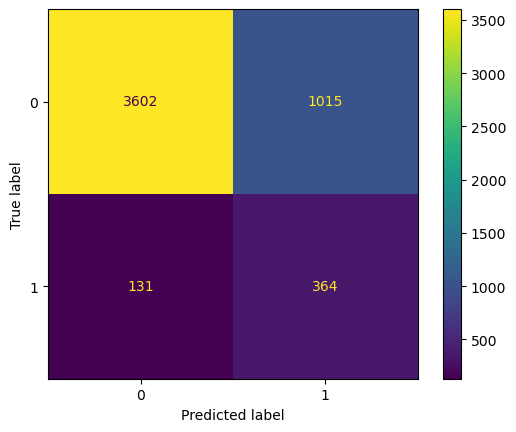

In [28]:
# Plotting theconfusion matrix
plot_confusion_matrix(grid_logit, X_test, y_test)
plt.show()

We can interpret the above confusion matrix in the following way:
- The upper-left cell contains the **True Negative (TN)** values. These are the outcomes that correctly predicted  𝑥 's rating in class 0 (i.e.negative class).
- The upper-right cell contains the **False Positive (FP)** values. These are the outcomes that incorrectly predicted that  𝑥  belongs to class 1 (i.e. positive class).
- The bottom-left cell contains the **False Negative (FN)** values. These are the outcomes that incorrectly predicted that  𝑥  belongs to class 0 (i.e. negative class).
- The bottom-right cell contains the **True Positive (TP)** values. These are the outcomes that correctly predicted that  𝑥  belongs to class 1 (i.e. positive class).

As we can see, we have a high rate of false positives most likely because we have fewer members of class 1 compared to class 0, since only the train set was balanced but not the test set.

Below, the test set is scored.

In [29]:
#Predict values based on new parameters
y_pred_acc_logit = grid_logit.predict(X_test)

In [30]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc_logit)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc_logit)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc_logit)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc_logit)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred_acc_logit)))

Accuracy Score : 0.7758215962441315
Precision Score : 0.2639593908629442
Recall Score : 0.7353535353535353
F1 Score : 0.38847385272145146
ROC AUC Score : 0.757756906294918


Our final model has an accuracy score of 77.5% and a recall score of 73.5% for the test set.

## K-Nearest Neighbors (KNN)

KNN is a classification algorithm that estimates how likely is to be a member of a specific group by looking at the labels of the data points around it (i.e. the neighbors).
<br>
<br>
The base model is presented below.

#### Base Model

In [31]:
# Instantiate the model
knn = KNeighborsClassifier()

# Fitting the model
knn.fit(X_train, y_train)

# Training and test scores
print(f"Train score: {knn.score(X_train, y_train)}")

Train score: 0.781182408074982


In [32]:
#Predict values based on new parameters
y_pred_acc = knn.predict(X_validation)

# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_validation,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_validation,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_validation,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_validation,y_pred_acc)))
print('ROC AUC Score : ' + str(roc_auc_score(y_validation,y_pred_acc)))

Accuracy Score : 0.7078578415389631
Precision Score : 0.19197117858980958
Recall Score : 0.626890756302521
F1 Score : 0.29393223010244285
ROC AUC Score : 0.6717230456002585


The accuracy of the train set was 78.1% compared to 70.6% of the validation set. This difference in accuracy is indicative of overfitting and hyperparameter optimization is needed.

#### Hyperparameter Optimization

Again, We will use GridSearchCV to loop through different parameters of KNN to select the best model. The parameters to be evaluated are:

- The scaler: `MinMaxScaler` or `StandardScaler`;
- The `n_neighbors`: Number of neighbors to use. From 1 to 59, with steps of 2.

In [33]:
# estimators
estimators = [('scaling', MinMaxScaler()),
              ('model', KNeighborsClassifier())]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)

# define parameter grid
param_grid = {
              'scaling': [MinMaxScaler(), StandardScaler()],
              'model': [KNeighborsClassifier()], 
              'model__n_neighbors': range(1, 60, 2)
}
# instantiate cross-validated grid search object with the steps and parameter grid
grid_knn = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose = 2,
    n_jobs= -1
)

# fit the grid to the unprocessed training data
grid_knn.fit(X_remainder, y_remainder);

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [34]:
# Score of the Validation set
grid_knn.score(X_remainder, y_remainder)

0.7267911200807265

In [35]:
# Best hyperparameters
grid_knn.best_params_

{'model': KNeighborsClassifier(n_neighbors=57),
 'model__n_neighbors': 57,
 'scaling': MinMaxScaler()}

The score of the cross-validation step is 72.7%. The best model has `n_neighbors` = 57 and MinMaxScaler
<br>
<br>
The confusion matrix is plotted below.

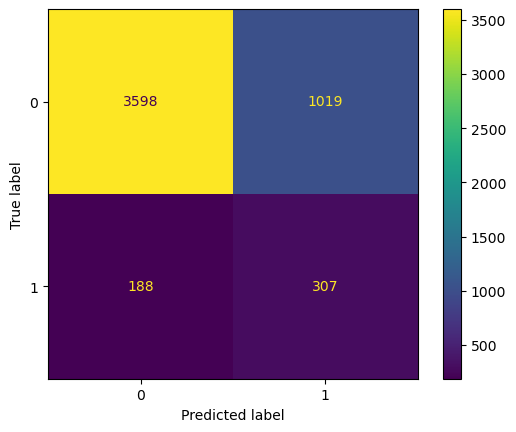

In [36]:
# Plotting theconfusion matrix
plot_confusion_matrix(grid_knn, X_test, y_test)
plt.show()

In [37]:
#Predict values based on new parameters
y_pred_acc_knn = grid_knn.predict(X_test)

In [38]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc_knn)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc_knn)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc_knn)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc_knn)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred_acc_knn)))

Accuracy Score : 0.7638888888888888
Precision Score : 0.23152337858220212
Recall Score : 0.6202020202020202
F1 Score : 0.33717737506864354
ROC AUC Score : 0.6997479669994289


The final KNN model has an accuracy score of 76.3% and a recall score of 62% for the test set. As we can see from the table below, the KNN had lower scores for all metrics compared to the logistic regression.

| Model | Validation Accuracy |Test Accuracy| Test Precision |Test Recall| Test F1 |Test ROC AUC |
| ----- | ------------------- |------------ | ------------------- |------------- | ------- |------------ |
| Logistic Regression | 75.6% | 77.6% | 26.4% | 73.5% | 38.8% | 75.8% 
| KNN| 72.7% | 76.3% | 23.1% | 62.0% | 33.6% | 70%

## Support Vector Machines (SVM)

The next classifier to be investigated is the SVM. This is a supervised machine learning method that maps data so as to maximize the width of the gap between the two categories. New examples are then mapped and predicted to belong to a category based on which side of the gap they fall. In their most simple form, SVM learn linear decision boundaries just like logistic regression.

## Base Model

In [39]:
from sklearn import svm
from sklearn.svm import SVC

# Instantiate the model
svm = svm.SVC()

# Fitting the model
svm.fit(X_train, y_train)

# Training and test scores
print(f"Train score: {svm.score(X_train, y_train)}")

Train score: 0.7905551550108147


In [40]:
#Predict values based on new parameters
y_pred_acc = svm.predict(X_validation)

# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_validation,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_validation,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_validation,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_validation,y_pred_acc)))
print('ROC AUC Score : ' + str(roc_auc_score(y_validation,y_pred_acc)))

Accuracy Score : 0.7649168568633844
Precision Score : 0.2589641434262948
Recall Score : 0.7647058823529411
F1 Score : 0.3869047619047619
ROC AUC Score : 0.7648227010609263


As seen above, the accuracy of the train set was 79% compared to 76.5% of the validation set. There is no clear sign of overfitting but hyperparameter optimization will be performed to tune the final model.

#### Hyperparameter Optimization

The parameters to be evaluated are in GridSearchCV are:

- The scaler: MinMaxScaler or StandardScaler;
- The gamma: Defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected;
- The C: Trades off misclassification of training against simplicity of the decision surface.

In [41]:
from sklearn import svm
from sklearn.svm import SVC

# estimators
estimators = [('scaling', MinMaxScaler()),
              ('model', svm.SVC())]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)

# define parameter grid
param_grid = {
              'model': [svm.SVC()], 
              'scaling': [MinMaxScaler(), StandardScaler()],
              'model__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'model__C': [0.001, 0.01, 0.1, 1, 10, 100]
}
# instantiate cross-validated grid search object with the steps and parameter grid
grid_svm = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose = 5,
    n_jobs = -1
)

# fit the grid to the unprocessed training data
grid_svm.fit(X_remainder, y_remainder);

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [42]:
# Score of the Validation set
grid_svm.score(X_remainder, y_remainder)

0.7525227043390514

In [43]:
# Best hyperparameters
grid_svm.best_params_

{'model': SVC(C=10, gamma=0.001),
 'model__C': 10,
 'model__gamma': 0.001,
 'scaling': MinMaxScaler()}

The score of the cross-validation step is 75.2%. The best model has `gamma` = 0.001, `C` = 10 and MinMaxScaler
<br>
<br>
The confusion matrix is plotted below.

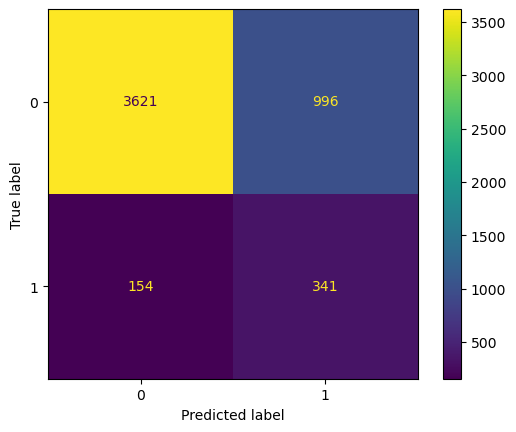

In [44]:
# Plotting theconfusion matrix
plot_confusion_matrix(grid_svm, X_test, y_test)
plt.show()

In [45]:
#Predict values based on new parameters
y_pred_acc_svm = grid_svm.predict(X_test)

In [46]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc_svm)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc_svm)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc_svm)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc_svm)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred_acc_svm)))

Accuracy Score : 0.775039123630673
Precision Score : 0.2550486163051608
Recall Score : 0.6888888888888889
F1 Score : 0.37227074235807855
ROC AUC Score : 0.736582196231319


The final SVM model has an accuracy score of 77.5% and a recall score of 68.8% for the test set. As we can see from the table below, although the SVM model had a comparable test accuracy compared to logistic regression, the test recall was smaller.

| Model | Validation Accuracy |Test Accuracy| Test Precision |Test Recall| Test F1 |Test ROC AUC |
| ----- | ------------------- |------------ | ------------------- |------------- | ------- |------------ |
| Logistic Regression | 75.6% | 77.6% | 26.4% | 73.5% | 38.8% | 75.8% 
| KNN| 72.7% | 76.3% | 23.1% | 62.0% | 33.6% | 70%
| SVM| 75.2% | 77.5% | 25.5% | 68.8% | 37.2% | 73.6%

## Decision Trees

The next classifier is a Decision Tree. This classifier works by making rules with the available features in order to best separate data points based in order to match the target.

#### Base Model

In [47]:
# Instantiate the model
dt = DecisionTreeClassifier()

# Fitting the model
dt.fit(X_train, y_train)

# Training and test scores
print(f"Train score: {dt.score(X_train, y_train)}")

Train score: 0.9992790194664743


In [48]:
#Predict values based on new parameters
y_pred_acc = dt.predict(X_validation)

# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_validation,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_validation,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_validation,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_validation,y_pred_acc)))
print('ROC AUC Score : ' + str(roc_auc_score(y_validation,y_pred_acc)))

Accuracy Score : 0.6799804369090316
Precision Score : 0.18391866913123844
Recall Score : 0.66890756302521
F1 Score : 0.2885103298296484
ROC AUC Score : 0.675038724643134


The results above show an important characteristic of decision trees: they can easily lead to overfitting as seen by the difference between the train and validation accuracies. This will be fixed in the hyperparameter optimization by optimizing the maximum depth of the tree.

#### Hyperparameter Optimization

Only the `max_depth` will be optimized in GridSearchCV since decision trees are not affected by scaling.  Using `max_depth`, we limit the number of consecutive splits that can be made, thus directly limiting the overall complexity of the tree. in other words, it can't develop overly long and complex branches to fit each data point.

In [49]:
# estimators
estimators = [('scaling', MinMaxScaler()),
              ('model', DecisionTreeClassifier())]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)

# define parameter grid
param_grid = {
              'scaling': [None],
              'model': [DecisionTreeClassifier()], 
              'model__max_depth': range(1, 10),
              'model__random_state': [1]
}
# instantiate cross-validated grid search object with the steps and parameter grid
grid_dt = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose = 5,
    n_jobs = -1
)

# fit the grid to the unprocessed training data
grid_dt.fit(X_remainder, y_remainder);

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [50]:
# Score of the Validation set
grid_dt.score(X_remainder, y_remainder)

0.7540363269424823

In [51]:
# Best hyperparameters
grid_dt.best_params_

{'model': DecisionTreeClassifier(max_depth=3, random_state=1),
 'model__max_depth': 3,
 'model__random_state': 1,
 'scaling': None}

The score of the cross-validation step is 75.4%. The overfitting problem seems to be resolved by optimizing the maximum depth. The best model has `max_depth` = 3.
<br>
<br>
The confusion matrix is plotted below

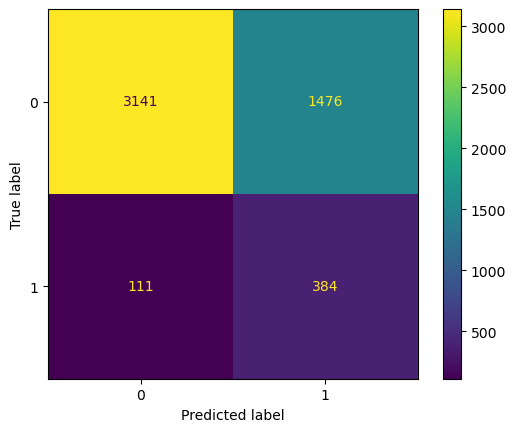

In [52]:
# Plotting theconfusion matrix
plot_confusion_matrix(grid_dt, X_test, y_test)
plt.show()

In [53]:
#Predict values based on new parameters
y_pred_acc_dt = grid_dt.predict(X_test)

In [54]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc_dt)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc_dt)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc_dt)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc_dt)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred_acc_dt)))

Accuracy Score : 0.6895539906103286
Precision Score : 0.2064516129032258
Recall Score : 0.7757575757575758
F1 Score : 0.32611464968152865
ROC AUC Score : 0.7280347332978913


Looking at the different scores of the final Decision Tree, it seems that we have a trade-off between accuracy and recall. While the test recall of 77.6% is the highest compared to all models so far, this model has the lowest accuracy (68.9%). 

| Model | Validation Accuracy |Test Accuracy| Test Precision |Test Recall| Test F1 |Test ROC AUC |
| ----- | ------------------- |------------ | ------------------- |------------- | ------- |------------ |
| Logistic Regression | 75.6% | 77.6% | 26.4% | 73.5% | 38.8% | 75.8% 
| KNN| 72.7% | 76.3% | 23.1% | 62.0% | 33.6% | 70%
| SVM| 75.2% | 77.5% | 25.5% | 68.8% | 37.2% | 73.6%
| Decision Tree| 75.4% | 68.9% | 20.6% | 77.6% | 32.6% | 72.8%

## Random Forest

Next, we will try to classify our data with the Random Forest method.
This is a machine learning technique for classification problems that uses ensemble learning, which is a technique that combines many classifiers (in this case, decision trees).

#### Base Model

In [55]:
# Instantiate the model
rf = RandomForestClassifier()

# Fitting the model
rf.fit(X_train, y_train)

# Training and test scores
print(f"Train score: {rf.score(X_train, y_train)}")

Train score: 0.9992790194664743


In [56]:
#Predict values based on new parameters
y_pred_acc = rf.predict(X_validation)

# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_validation,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_validation,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_validation,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_validation,y_pred_acc)))
print('ROC AUC Score : ' + str(roc_auc_score(y_validation,y_pred_acc)))

Accuracy Score : 0.745679817411151
Precision Score : 0.24457384859714135
Recall Score : 0.7764705882352941
F1 Score : 0.37198067632850246
ROC AUC Score : 0.7594214287989974


Similar to the Decision Tree we see clear overfitting of the training dataset, illustrated by the accuracy of almost 100% compared to a test accuracy of only 74.8%. A solution for this problem will again be explored with hyperparameter optimization.

#### Hyperparameter Optimization

Similar to the Decision Tree, scaling is not necessary for the Random Forest classifier. 
<br>
<br>
Also similarly to the Decision Tree, the overall complexity of the trees will be limited by the parameter `max_depth`.
<br>
<br>
The new parameter to be added here is `n_estimators`, which represents the number of trees in the forest.

In [57]:
# estimators
estimators = [('scaling', MinMaxScaler()),
              ('model', RandomForestClassifier())]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)

# define parameter grid
param_grid = {
              'scaling': [None],
              'model': [RandomForestClassifier()], 
              'model__max_depth': range(1, 10),
              'model__n_estimators': np.arange(1, 100),
              'model__random_state': [1]
}
# instantiate cross-validated grid search object with the steps and parameter grid
grid_rf = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose = 5,
    n_jobs = -1
)

# fit the grid to the unprocessed training data
grid_rf.fit(X_remainder, y_remainder);

Fitting 5 folds for each of 891 candidates, totalling 4455 fits


In [58]:
# Score of the Validation set
grid_rf.score(X_remainder, y_remainder)

0.7633703329969728

In [59]:
# Best hyperparameters
grid_rf.best_params_

{'model': RandomForestClassifier(max_depth=6, n_estimators=77, random_state=1),
 'model__max_depth': 6,
 'model__n_estimators': 77,
 'model__random_state': 1,
 'scaling': None}

The score of the cross-validation is 76.3%. The overfitting problem seems to be resolved by optimizing the maximum depth and number of trees. The best model has `max_depth` = 6 and `n_estimators` = 77.
<br>
<br>
The confusion matrix is plotted below

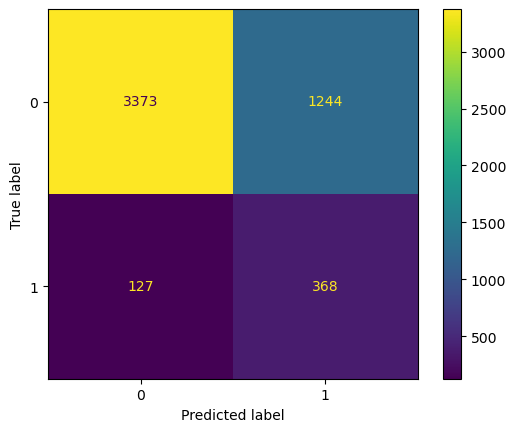

In [60]:
# Plotting theconfusion matrix
plot_confusion_matrix(grid_rf, X_test, y_test);
plt.show()

In [61]:
#Predict values based on new parameters
y_pred_acc_rf = grid_rf.predict(X_test)

In [62]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc_rf)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc_rf)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc_rf)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc_rf)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred_acc_rf)))

Accuracy Score : 0.7318075117370892
Precision Score : 0.228287841191067
Recall Score : 0.7434343434343434
F1 Score : 0.3493118177503559
ROC AUC Score : 0.7369976568806977


Compared to the Decision Tree, the final Random Forest model seems to be more balanced between accuracy (73.1%) and recall (74.3%). Compared to the Logistic Regression, the Random Forest has a smaller accuracy but higher recall.

| Model | Validation Accuracy |Test Accuracy| Test Precision |Test Recall| Test F1 |Test ROC AUC |
| ----- | ------------------- |------------ | ------------------- |------------- | ------- |------------ |
| Logistic Regression | 75.6% | 77.6% | 26.4% | 73.5% | 38.8% | 75.8% 
| KNN| 72.7% | 76.3% | 23.1% | 62.0% | 33.6% | 70%
| SVM| 75.2% | 77.5% | 25.5% | 68.8% | 37.2% | 73.6%
| Decision Tree| 75.4% | 68.9% | 20.6% | 77.6% | 32.6% | 72.8%
| Random Forest| 76.3% | 73.1% | 22.8% | 74.3% | 34.9% | 73.7%

## XGBoost

Next, we will explore the eXtreme Gradient Boosting (XGBoost) algorithm. It is an implementation of gradient boosted decision trees (i.e. an ensemble method) designed for speed and performance compared to the sci-kit learn implementation. 

##### Base Model

In [63]:
# Instantiate the model
XGB_model = XGBClassifier()

# Fitting the model
XGB_model.fit(X_train, y_train)

# Training and test scores
print(f"Train score: {logreg.score(X_train, y_train)}")

Train score: 0.7653208363374189


In [64]:
#Predict values based on new parameters
y_pred_acc = XGB_model.predict(X_validation)

# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_validation,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_validation,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_validation,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_validation,y_pred_acc)))
print('ROC AUC Score : ' + str(roc_auc_score(y_validation,y_pred_acc)))

Accuracy Score : 0.7295402673622432
Precision Score : 0.22406639004149378
Recall Score : 0.7260504201680672
F1 Score : 0.3424494649227111
ROC AUC Score : 0.72798278365327


The accuracy of the train set was 76.5% compared to 72.9% of the validation set. the similarity of these scores suggests that there is no overfitting.  
<br>
<br>
The hyperparameter optimization is presented below.

##### Hyperparameter Optimization

In [65]:
# estimators
estimators = [('scaling', MinMaxScaler()),
              ('model', XGBClassifier())]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)

# define parameter grid
param_grid = {
              'scaling': [None],
              'model': [XGBClassifier()], 
              'model__max_depth': range(1, 10),
              'model__n_estimators': np.arange(1, 200, 10),
              'model__random_state': [1]
}
# instantiate cross-validated grid search object with the steps and parameter grid
grid_xgb = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose = 5,
    n_jobs = -1
)

# fit the grid to the unprocessed training data
grid_xgb.fit(X_remainder, y_remainder);

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [66]:
# Score of the Validation set
grid_xgb.score(X_remainder, y_remainder)

0.7651362260343088

In [67]:
# Best hyperparameters
grid_xgb.best_params_

{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=2,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=31, n_jobs=None, num_parallel_tree=None,
               random_state=1, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
 'model__max_depth': 2,
 'model__n_estimators': 31,
 'model__random_state': 1,
 'scaling': None}

The score of the cross-validation is 76.5%. The best parameters identified were `max_depth` = 2 and `n_estimators` = 31.
<br>
<br>
The confusion matrix is plotted below

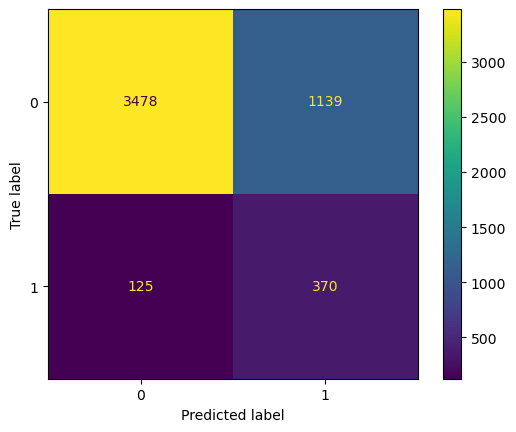

In [68]:
# Plotting theconfusion matrix
plot_confusion_matrix(grid_xgb, X_test, y_test);
plt.show()

In [69]:
#Predict values based on new parameters
y_pred_acc_xgb = grid_xgb.predict(X_test)

In [70]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc_xgb)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc_xgb)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc_xgb)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc_xgb)))
print('ROC AUC Score : ' + str(roc_auc_score(y_test,y_pred_acc_xgb)))

Accuracy Score : 0.7527386541471048
Precision Score : 0.24519549370444002
Recall Score : 0.7474747474747475
F1 Score : 0.36926147704590817
ROC AUC Score : 0.7503888790438498


| Model | Validation Accuracy |Test Accuracy| Test Precision |Test Recall| Test F1 |Test ROC AUC |
| ----- | ------------------- |------------ | ------------------- |------------- | ------- |------------ |
| Logistic Regression | 75.6% | 77.6% | 26.4% | 73.5% | 38.8% | 75.8% 
| KNN| 72.7% | 76.3% | 23.1% | 62.0% | 33.6% | 70%
| SVM| 75.2% | 77.5% | 25.5% | 68.8% | 37.2% | 73.6%
| Decision Tree| 75.4% | 68.9% | 20.6% | 77.6% | 32.6% | 72.8%
| Random Forest| 76.3% | 73.1% | 22.8% | 74.3% | 34.9% | 73.7%
| XGBoost| 76.5% | 75.3% | 24.5% | 74.7% | 36.9% | 75.0%

The XGBoost model seemed to slightly improve the metrics compared to the Random Forest. However, this model also seems to have worse scores compared to the Logistic Regression.

# Conclusion

The conclusions from these analyses are:
- Converging to the insights from the EDA of Part 1, the coefficients from the logistic regression shows that the likelihood of a bird strike to cause damage is higher for small one-engined aircrafts, incidents involving animals of large size and in large groups, during descent or climb, and at altitudes higher than 1000 feet. 
- Among the models tested so far, Logistic Regression and SVM outperform the other models in terms of accuracy, while the recall was higher for the Decision Tree model. However, in general, gains in accuracy seem to come with a cost in recall, and vice versa. In this regard, the most balanced models in terms of these two metrics were Random Forest and XGBoost.
<br>
<br>
In Part 3 of this project, a Neural Network will be built to continue the predictive analysis of damaging bird strikes. The results from this advanced model will be compared to the results of the models from this notebook.